In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

ModuleNotFoundError: No module named 'pandas'

In [2]:
date_format = '%B %d, %Y'

In [3]:
def make_plot(x, y, title : str):
    x = x.apply(pd.to_datetime, format = date_format)
    
    plt.figure().set_figwidth(15)
    plt.title(label=title)
    plt.plot(x, y)
    plt.gcf().autofmt_xdate()

    return plt.show()

## Paid Orders

In [4]:
paid_orders = pd.read_csv('Data\Edu_TS_1_Paid.csv', index_col=0)
paid_orders

,Date,Orders
0,"May 1, 2023",588
1,"May 2, 2023",532
2,"May 3, 2023",599
3,"May 4, 2023",559
4,"May 5, 2023",480
...,...,...
170,"October 18, 2023",1058
171,"October 19, 2023",1065
172,"October 20, 2023",1060
173,"October 21, 2023",1050


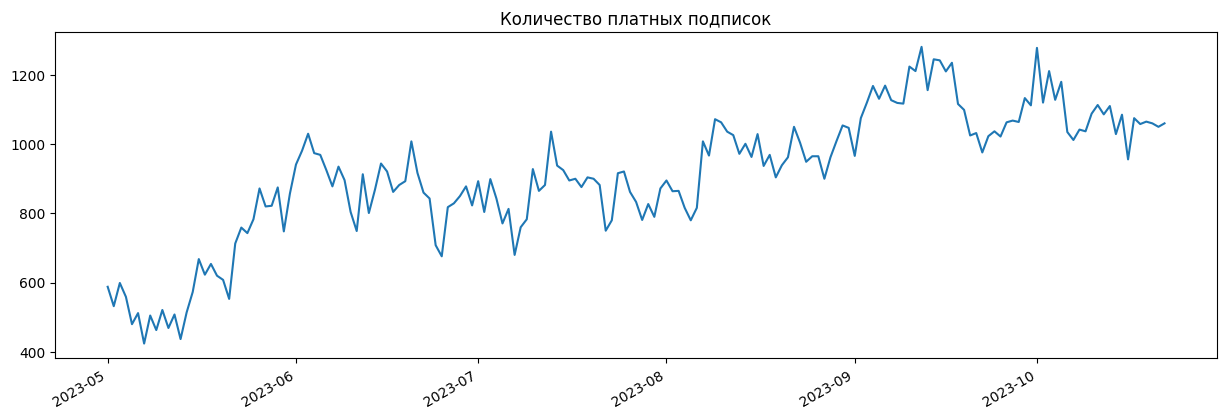

In [5]:
make_plot(paid_orders.Date, paid_orders.Orders, "Количество платных подписок")

## Trial Orders

In [6]:
trial_orders = pd.read_csv('Data/Edu_TS_1_Trial.csv', index_col=0)
trial_orders

,Date,Orders
0,"May 1, 2023",987
1,"May 2, 2023",948
2,"May 3, 2023",956
3,"May 4, 2023",972
4,"May 5, 2023",979
...,...,...
170,"October 18, 2023",332
171,"October 19, 2023",307
172,"October 20, 2023",235
173,"October 21, 2023",322


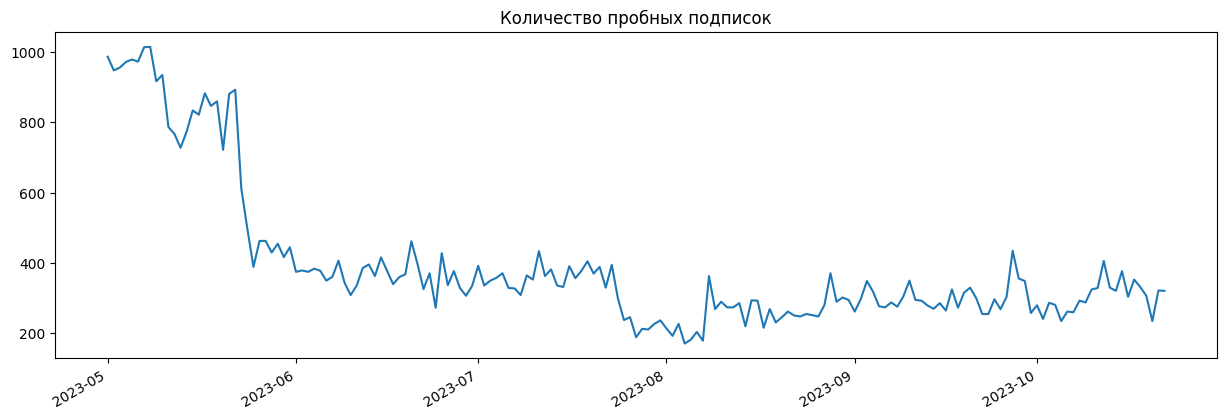

In [7]:
make_plot(trial_orders.Date, trial_orders.Orders, title='Количество пробных подписок')

## Traffic

In [8]:
traffic = pd.read_csv('Data/Edu_TS_2_Traffic.csv', index_col=0)
traffic

,Date,Unique Visitors
0,"May 1, 2023",34010
1,"May 2, 2023",42876
2,"May 3, 2023",42608
3,"May 4, 2023",41266
4,"May 5, 2023",38584
...,...,...
170,"October 18, 2023",52076
171,"October 19, 2023",51372
172,"October 20, 2023",48951
173,"October 21, 2023",43434


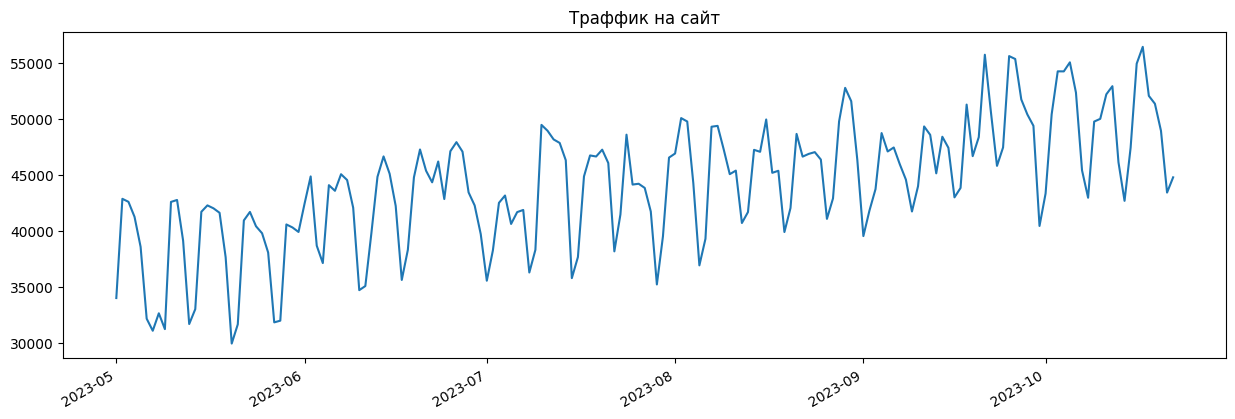

In [9]:
make_plot(traffic['Date'], traffic['Unique Visitors'], "Траффик на сайт")

## Paid Carts Traffic

In [10]:
carts_paid = pd.read_csv('Data/Edu_TS_3_Carts_Paid.csv', index_col=0)
carts_paid

,Date,Unique Visitors
0,"May 1, 2023",412
1,"May 2, 2023",402
2,"May 3, 2023",364
3,"May 4, 2023",336
4,"May 5, 2023",322
...,...,...
170,"October 18, 2023",876
171,"October 19, 2023",848
172,"October 20, 2023",851
173,"October 21, 2023",918


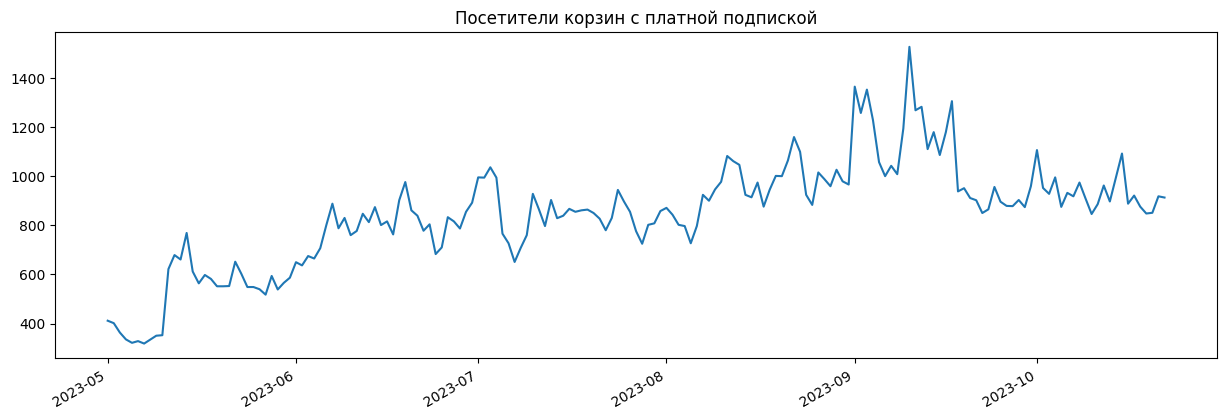

In [11]:
make_plot(carts_paid['Date'], carts_paid['Unique Visitors'], "Посетители корзин с платной подпиской")

## Trial Carts Paid

In [18]:
carts_trial = pd.read_csv('Data/Edu_TS_3_Carts_Trial.csv', index_col=0)
carts_trial

,Date,Unique Visitors
0,"May 1, 2023",3
1,"May 2, 2023",3
2,"May 4, 2023",1
3,"May 5, 2023",8
4,"May 8, 2023",1
...,...,...
167,"October 18, 2023",1487
168,"October 19, 2023",1427
169,"October 20, 2023",1350
170,"October 21, 2023",1638


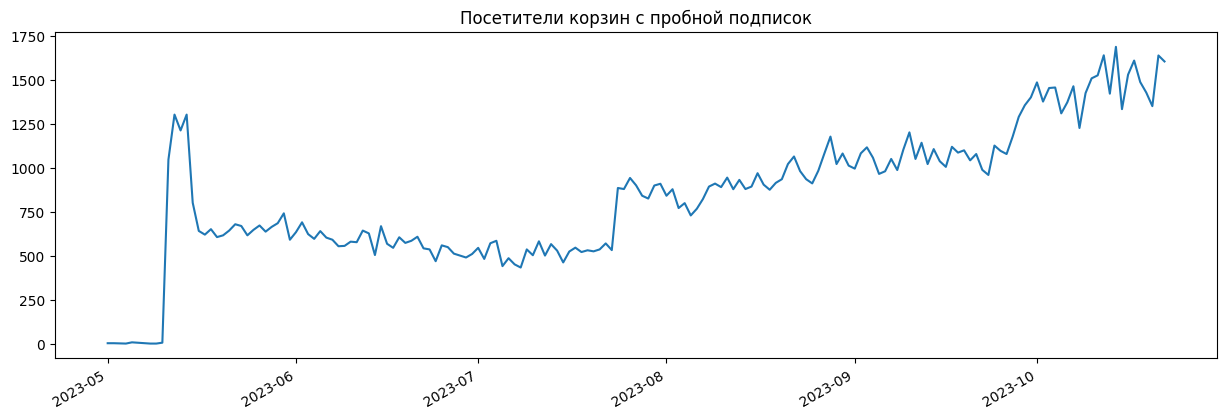

In [19]:
make_plot(carts_trial['Date'], carts_trial['Unique Visitors'], "Посетители корзин с пробной подписок")

## Average Order Value

In [14]:
aov_paid = pd.read_csv('Data/Edu_TS_4_Aov.csv', index_col=0)
aov_paid

,Date,Revenue,Orders,AOV,Product_id
0,2023-05-01,0.000,42,0.000000,NaN
1,2023-05-01,0.000,0,NaN,1.0
2,2023-05-01,0.000,0,NaN,2.0
3,2023-05-01,64.554,6,10.759000,9.0
4,2023-05-01,1109.654,39,28.452667,10.0
...,...,...,...,...,...
2785,2023-10-22,0.000,0,NaN,8.0
2786,2023-10-22,21.924,4,5.481000,14.0
2787,2023-10-22,0.000,0,NaN,15.0
2788,2023-10-22,205.366,148,1.387608,16.0


In [15]:
aov_paid['Date'] = pd.to_datetime(aov_paid['Date'], format='%Y-%m-%d')

In [16]:
df = pd.pivot_table(data=aov_paid, values='AOV',
               index='Date', aggfunc="sum")
df = df.reset_index()
df.Date = pd.to_datetime(df.Date)

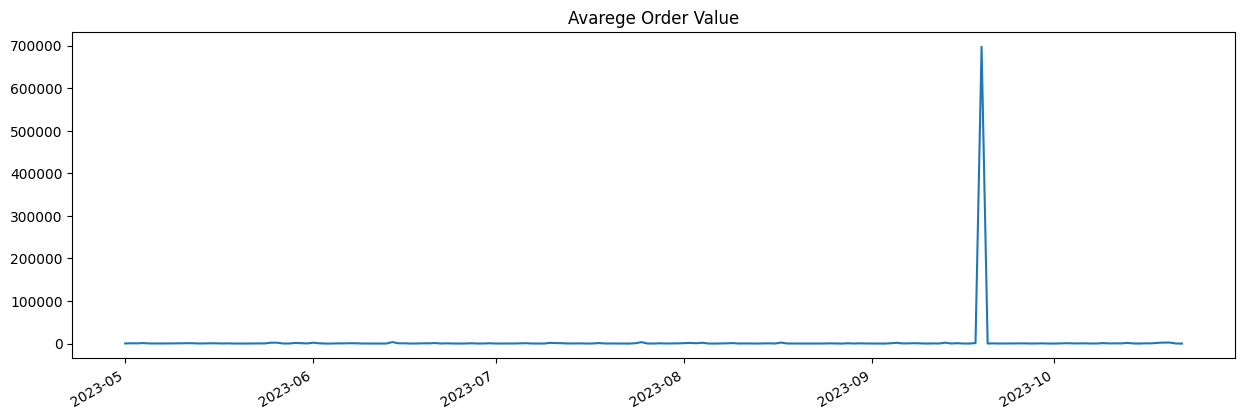

In [17]:
plt.figure().set_figwidth(15)
plt.title(label='Avarege Order Value')
plt.plot(df.Date, df.AOV)
plt.gcf().autofmt_xdate()

plt.show()

In [20]:
n = input().split()

def max_spisok(spisok: str) -> int:
    max = 0
    for i in spisok:
        if int(i) > max:
            max = int(i)
    return max

max_spisok(n)

42